Install and import modules

In [1]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 858.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import pandas as pd
import io #to load uploaded data
from bertopic import BERTopic


In [3]:
#load data
from google.colab import files
uploaded = files.upload()

Saving kc_wiki_with_summary.csv to kc_wiki_with_summary.csv


In [4]:
#load wiki data with summary for KC
kc_wiki_with_summary= pd.read_csv(io.BytesIO(uploaded['kc_wiki_with_summary.csv']))

In [5]:
import geopandas as gpd
#select certain columns from wiki data
kc_wiki = kc_wiki_with_summary[["gt_page_id",
                   "gt_lon",
                   "gt_lat",
                   "geometry",
                   "page_title",
                   "page_summary"]]
#set geometry for wiki data
kc_wiki = gpd.GeoDataFrame(kc_wiki,
                           geometry=gpd.points_from_xy(kc_wiki.gt_lon,
                                                       kc_wiki.gt_lat),
                                                       crs="EPSG:4326").to_crs('epsg:27700')

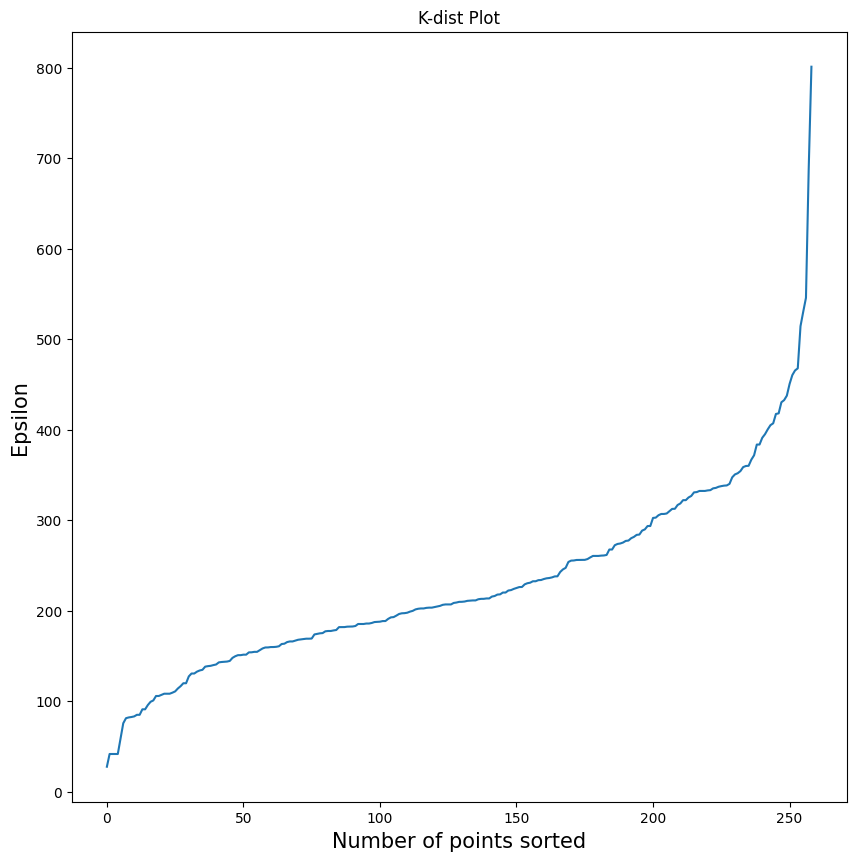

In [8]:
import numpy as np
kc_wiki['easting'] = kc_wiki['geometry'].x
kc_wiki['northing'] = kc_wiki['geometry'].y
kc_coords = kc_wiki[['easting', 'northing']].to_numpy()
#finding the optimum epsilon
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
#Codes inspired from Medium post by Tara Mullin (2020), titled : DBSCAN Parameter Estimation Using Python
#Available at: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(kc_coords)
distances, indices = neighbors_fit.kneighbors(kc_coords)
distances = np.sort(distances, axis=0)
distances = distances[:,4]
#plot data
plt.figure(figsize=(10, 10))
plt.title('K-dist Plot')
plt.xlabel('Number of points sorted', fontsize=15)
plt.ylabel('Epsilon',fontsize=15)
plt.plot(distances)

In [13]:
#run dbscan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=200, min_samples=5, metric='euclidean')
db = dbscan.fit(kc_coords)
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
num_noise = list(cluster_labels).count(-1)
print(num_clusters)
print(num_noise)
#add cluster labels to dataset
kc_wiki['cluster'] = cluster_labels

16
95


[<POLYGON ((527917.541 178457.123, 527774.985 178606.986, 527999.392 178793.0...>, <POLYGON ((525709.446 179359.01, 525460.494 179534.606, 525525.029 179797.98...>, <POLYGON ((527136.424 178053.646, 526834.839 178140.7, 526605.696 178290.106...>, <POLYGON ((525222.193 180437.452, 525080.67 180545.239, 525250.471 180620.51...>, <POLYGON ((526343.288 178617.139, 526155.118 178657.904, 526026.859 178788.2...>, <POLYGON ((526573.211 177766.983, 526509.341 177821.031, 526451.31 177919.73...>, <POLYGON ((527430.882 178997.269, 527332.022 179208.994, 527474.281 179236.0...>, <POLYGON ((527272.543 178785.445, 526871.989 178990.639, 526683.559 179224.9...>, <POLYGON ((527789.54 178974.42, 527688.096 179018.854, 527897.354 179443.863...>, <POLYGON ((526857.864 177495.891, 526848.626 177618.68, 526846.761 177662.52...>, <POLYGON ((527461.812 177710.165, 527493.092 177931.27, 527851.395 178048.69...>, <POLYGON ((527206.943 178539.448, 527031.172 178577.709, 526891.008 178642.8...>, <POLYGON ((5244

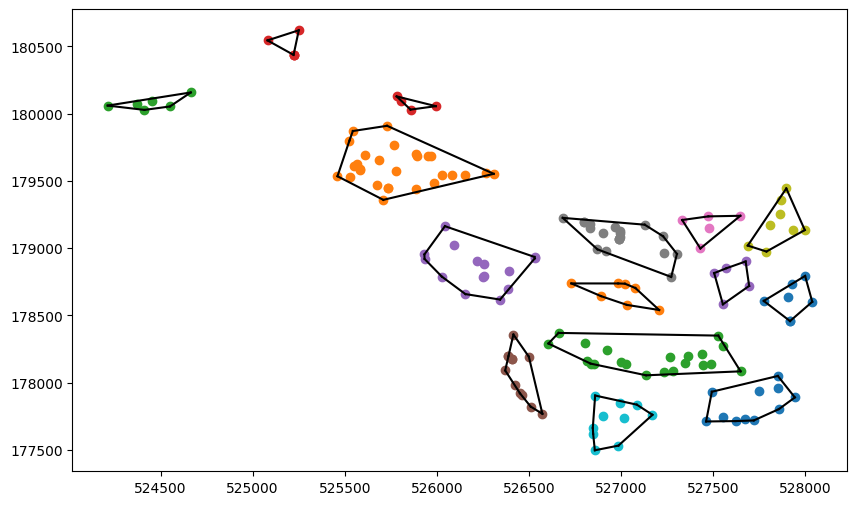

In [14]:
#Regionalise
#create convex hull
#Reference: The Scipy Community, Available at:https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#remove noise
remove = kc_wiki[kc_wiki['cluster'] == -1].index
kc_wiki = kc_wiki.drop(remove)
#select only necessary column
db_cl = kc_wiki[["easting",
                   "northing",
                   "cluster"]]

#run convexhull for each clusters seperately
#create a list of convex hull
h = [] #for list of polygon coordinates from chull
import geopandas as gpd
#load boundary file for kc
#kc_boundary = gpd.read_file('../../data/boundary_london/kc.shp')
# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
#kc_boundary.to_crs(epsg=27700).plot(ax=ax,
                                  #color= 'lightgrey', alpha= 0.2,
                                  #edgecolor = '0.5')
for i in range(0,15):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["easting", "northing"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    h.append(db_cl_i[ch_i.vertices,:].tolist())
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')
#plt.savefig('../../docs/docs_wiki_clustering/dbscan_wiki_kc_reg.png')
#for generating polygon from ordered manner
#Ref: https://stackoverflow.com/questions/61740032/how-to-convert-convex-hull-vertices-into-a-geopandas-polygon
from shapely.geometry import MultiPoint
c_h = []
for hull in h:
    c_h.append(MultiPoint(hull).convex_hull)

print(c_h)


Run Bertopic for RBKC

In [16]:
#run model
#Reference: Maarten Grootendorst(2022)
#Available at: https://github.com/MaartenGr/BERTopic
summary_kc = kc_wiki['page_summary'].tolist()
#extract embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
#reduce dimension
from umap import UMAP
umap_model = UMAP(n_neighbors=2,
                  n_components=4,
                  min_dist=0.0,
                  metric='cosine')
#clustering
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size = 2,
                        min_samples = 2,
                        gen_min_span_tree = True,
                        prediction_data = True)

#Tokenize topics
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english")
# Create topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer()
topic_model = BERTopic( embedding_model=embedding_model,
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        vectorizer_model=cv,
                        ctfidf_model=ctfidf_model,
                        nr_topics=6,
                        language="english",
                        calculate_probabilities=True,
                        verbose=True)
topics, probs = topic_model.fit_transform(summary_kc)

2025-03-25 13:58:57,264 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

2025-03-25 13:59:13,377 - BERTopic - Embedding - Completed ✓
2025-03-25 13:59:13,379 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-25 13:59:13,525 - BERTopic - Dimensionality - Completed ✓
2025-03-25 13:59:13,527 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-25 13:59:13,558 - BERTopic - Cluster - Completed ✓
2025-03-25 13:59:13,559 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-03-25 13:59:13,636 - BERTopic - Representation - Completed ✓
2025-03-25 13:59:13,637 - BERTopic - Topic reduction - Reducing number of topics
2025-03-25 13:59:13,647 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-25 13:59:13,691 - BERTopic - Representation - Completed ✓
2025-03-25 13:59:13,695 - BERTopic - Topic reduction - Reduced number of topics from 38 to 6


Visualise topics

In [17]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7,-1_mews_university_london_embassy,"[mews, university, london, embassy, college, d...","[Heythrop College, University of London, was a..."
1,0,120,0_street_london_kensington_chelsea,"[street, london, kensington, chelsea, road, ho...","[Royal Hospital Road is a street in Chelsea, L..."
2,1,16,1_museum_victoria_exhibition_society,"[museum, victoria, exhibition, society, london...",[A statue of Queen Victoria stands near Kensin...
3,2,12,2_diplomatic_kingdom_united_mission,"[diplomatic, kingdom, united, mission, embassy...",[The Embassy of Uzbekistan in London is the di...
4,3,6,3_dandie_tom_store_apple,"[dandie, tom, store, apple, boutique, crittle,...",[Acme Attractions was a London clothing store ...
5,4,3,4_restaurant_indian_michelin_aubergine,"[restaurant, indian, michelin, aubergine, awar...",[The Bombay Brasserie is an Indian restaurant ...


In [18]:
bertopic_df = pd.DataFrame(topic_model.get_document_info(summary_kc))

In [19]:
topic_model.visualize_barchart()

In [20]:
topic_model.generate_topic_labels()

['-1_mews_university_london',
 '0_street_london_kensington',
 '1_museum_victoria_exhibition',
 '2_diplomatic_kingdom_united',
 '3_dandie_tom_store',
 '4_restaurant_indian_michelin']

In [21]:
#Name the Bertopic topics
def get_bertopic_name(topic):
    if topic == 3:
        return 'Boutique Shopping'
    elif topic == 0:
        return 'Renowned Roads & Streets'
    elif topic == 1:
        return 'Museums and Exhibition'
    elif topic == 2:
        return 'Diplomatic Zone'
    elif topic == 4:
        return 'Eateries'
    else:
        return 'Others'
bertopic_df['Bertopic_Wiki'] = bertopic_df['Topic'].apply(get_bertopic_name)

In [31]:
pip install gensim

Evaluate the model

In [32]:
#code adopted from Maarten Grootendorst (2021)
#Available at: https://github.com/MaartenGr/BERTopic/issues/90
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
documents = pd.DataFrame({"Document": summary_kc,
                          "ID": range(len(summary_kc)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})
cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
#words = vectorizer.get_feature_names()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)]
               for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_uci')
coherence = coherence_model.get_coherence()

coherence

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
coherence

-2.0792123586420406

In [26]:
bertopic_df

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,Bertopic_Wiki
0,Wyndham House is a large stone building on the...,0,0_street_london_kensington_chelsea,"[street, london, kensington, chelsea, road, ho...","[Royal Hospital Road is a street in Chelsea, L...",street - london - kensington - chelsea - road ...,1.000000,False,Renowned Roads & Streets
1,"Zaika is an Indian restaurant in Kensington, L...",4,4_restaurant_indian_michelin_aubergine,"[restaurant, indian, michelin, aubergine, awar...",[The Bombay Brasserie is an Indian restaurant ...,restaurant - indian - michelin - aubergine - a...,1.000000,True,Eateries
2,Mortimer House is a large detached house on Eg...,0,0_street_london_kensington_chelsea,"[street, london, kensington, chelsea, road, ho...","[Royal Hospital Road is a street in Chelsea, L...",street - london - kensington - chelsea - road ...,0.600487,False,Renowned Roads & Streets
3,The Yemenite ambassador to the Court of St Jam...,2,2_diplomatic_kingdom_united_mission,"[diplomatic, kingdom, united, mission, embassy...",[The Embassy of Uzbekistan in London is the di...,diplomatic - kingdom - united - mission - emba...,0.807226,False,Diplomatic Zone
4,The Romanian Ambassador to the Court of St Jam...,2,2_diplomatic_kingdom_united_mission,"[diplomatic, kingdom, united, mission, embassy...",[The Embassy of Uzbekistan in London is the di...,diplomatic - kingdom - united - mission - emba...,0.722147,False,Diplomatic Zone
...,...,...,...,...,...,...,...,...,...
159,The Chelsea Arts Club is a private members clu...,1,1_museum_victoria_exhibition_society,"[museum, victoria, exhibition, society, london...",[A statue of Queen Victoria stands near Kensin...,museum - victoria - exhibition - society - lon...,1.000000,False,Museums and Exhibition
160,Peter Jones & Partners is a large department s...,0,0_street_london_kensington_chelsea,"[street, london, kensington, chelsea, road, ho...","[Royal Hospital Road is a street in Chelsea, L...",street - london - kensington - chelsea - road ...,0.347489,False,Renowned Roads & Streets
161,Chelsea Embankment is part of the Thames Emban...,0,0_street_london_kensington_chelsea,"[street, london, kensington, chelsea, road, ho...","[Royal Hospital Road is a street in Chelsea, L...",street - london - kensington - chelsea - road ...,0.222951,False,Renowned Roads & Streets
162,The Rosalinde and Arthur Gilbert Collection is...,1,1_museum_victoria_exhibition_society,"[museum, victoria, exhibition, society, london...",[A statue of Queen Victoria stands near Kensin...,museum - victoria - exhibition - society - lon...,0.264609,False,Museums and Exhibition


In [23]:
bertopic_df.to_csv('bertopic_kc_wiki_nov.csv')
files.download('bertopic_kc_wiki_nov.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
bertopic_gdf.to_csv('bertopic_kc_wiki.csv')
files.download('bertopic_kc_wiki.csv')

NameError: name 'bertopic_gdf' is not defined